# Recommendation of books
Author: Luke Huisman<br>
Student number: 684651<br>
Date: 22-03-2025

Before working within this notebook, please ensure that you have activated your virtual environment (venv). Activating the venv ensures that you are using the correct versions of the packages required for this notebook.

To activate the venv, use the following commands:

- On Windows:
    ```sh
    .\venv\Scripts\activate
    ```

- On macOS/Linux:
    ```sh
    source venv/bin/activate
    ```

For this notebook to work you must have installed the following packages (usually via pip install *packageName*:
* pandas

From these we will need the following libraries:

In [242]:
import subprocess
import sys

def install(package):
    print(f"Installing {package}, please wait...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import pandas as pd
except ImportError:
    install('pandas')
    import pandas as pd
try:
    import matplotlib.pyplot as plt
except ImportError:
    install('matplotlib')
    import matplotlib.pyplot as plt

# 1. The Item-Based Recommender

We are going to build an item-based recommender for books. In this recommender we could for example recommend books that are similar to a book that a user has already read.

To begin you'll need to download the dataset from [kaggle](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset). Move the dataset to the [/data](/data) folder and extract the files in there. The dataset contains a few files, but we won't be using all of them.

We'll only be using the books.csv and ratings.csv files. The books.csv file contains information about the books, and the ratings.csv file contains information about the ratings that users have given to the books.

In [243]:
# enter code to load your example data file(s)
try:
    books_df: pd.DataFrame = pd.read_csv('data/books.csv')
    ratings_df: pd.DataFrame = pd.read_csv('data/ratings.csv')
except FileNotFoundError:
    print("Please download the data file(s) from kaggle repository.")
    sys.exit(1)

/var/folders/jq/jqsf6b8512l0c_6st5dn6zsm0000gn/T/ipykernel_19087/1650831247.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df: pd.DataFrame = pd.read_csv('data/books.csv')


## Let's take a quick look at the data head

In [244]:
print(books_df.head())
print(ratings_df.head())

         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/

The data from the dataset is quite extensive, but it also has a lot of unneccesary columns. We can for example from the books dataset drop all columns except for the ISBN and the Book-Title as we won't be needing the other columns for the recommender system.

We furthermore will clean the data a little bit before hand by removing any ratings that are 0, as these are not useful for our recommender system. We will also remove any entries where the user has given multiple ratings for the same book, as this is likely an error in the dataset.

In [245]:
# Only select from the books_df the columns ISBN and Book-Title
books_df = books_df[['ISBN', 'Book-Title']]

# Remove all rows from the ratings_df where the Book-Rating is 0
ratings_df = ratings_df[ratings_df['Book-Rating'] != 0]

# Remove all duplicate ratings where the same user rated the same book multiple times
ratings_df = ratings_df.drop_duplicates(subset=['ISBN', 'User-ID'])

# Merge the two dataframes on the ISBN column
df = books_df.merge(ratings_df, on='ISBN')

Now that the data has been picked, we can take another look at the data.

In [246]:
print(df.head())

         ISBN    Book-Title  User-ID  Book-Rating
0  0002005018  Clara Callan        8            5
1  0002005018  Clara Callan    11676            8
2  0002005018  Clara Callan    67544            8
3  0002005018  Clara Callan   116866            9
4  0002005018  Clara Callan   123629            9


This already looks a lot better. We can see that the data is now much more readable and that we have removed a lot of the unnecessary columns.

We also need to take the counts into consideration so lets keep those into their own dataframe, together with the average score:

In [247]:
# Create a new dataframe where each row is a book and the columns are the average rating and the number of ratings
average_ratings = df.groupby('ISBN')['Book-Rating'].agg(['mean', 'count'])
# Reset the index so that ISBN is a column
average_ratings.reset_index(inplace=True)
# Rename the columns to Average-Rating and Number-of-Ratings
average_ratings.columns = ['ISBN', 'Average-Rating', 'Number-of-Ratings']

To decide on a cut-off point as minimum number of scores to be eligable we can plot the number of scores in a histogram:

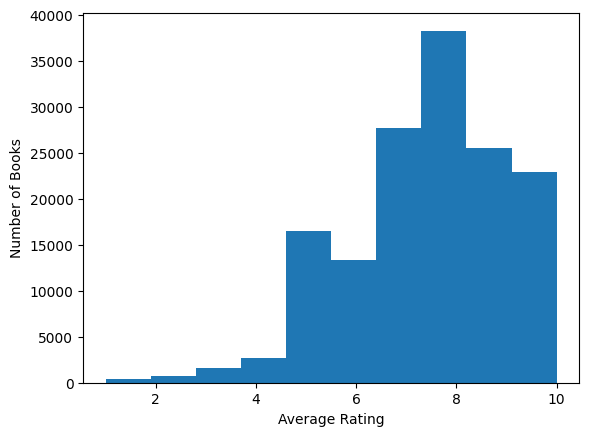

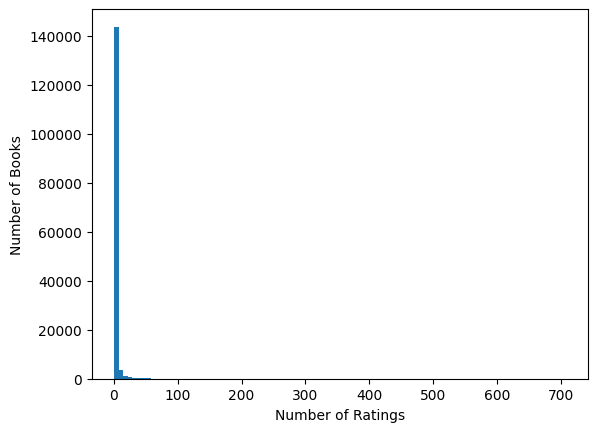

In [248]:
plt.hist(average_ratings['Average-Rating'], bins=10)
plt.xlabel('Average Rating')
plt.ylabel('Number of Books')
plt.show()

plt.hist(average_ratings['Number-of-Ratings'], bins=100)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Books')
plt.show()

From the histogram we can see that there are a lot of book with a lot amount of ratings, while most books have very few ratings. We can see that the majority of books have less than 100 ratings. We can use this information to decide on a cut-off point. We can for example decide that a book needs at least 25 ratings to be eligible for the recommender system.

Let's drop all rows where the number of ratings is less than 25 and take another peek at the data:

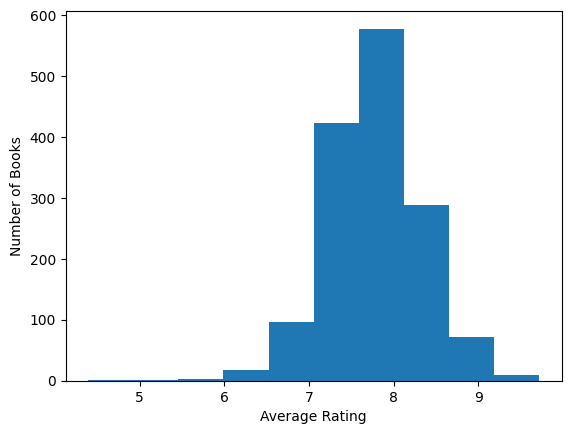

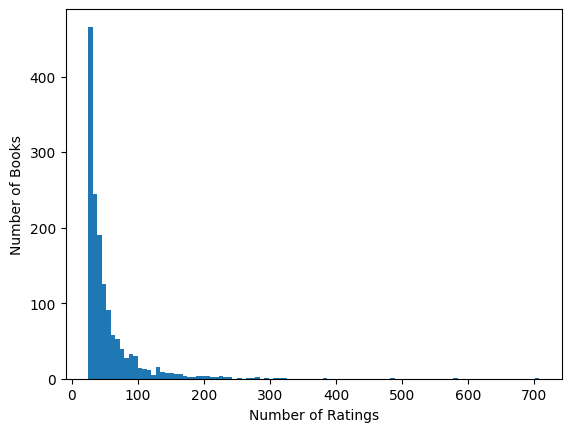

In [249]:
average_ratings = average_ratings[average_ratings["Number-of-Ratings"] >= 25]

plt.hist(average_ratings["Average-Rating"], bins=10)
plt.xlabel("Average Rating")
plt.ylabel("Number of Books")
plt.show()

plt.hist(average_ratings["Number-of-Ratings"], bins=100)
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Books")
plt.show()

We can see that many of the very low ratings have been removed from the dataset. We can loosly conclude that the ratings and books that have been removed are not very popular or were outliers in the dataset. Making the dataset more reliable for our recommender system.

Finally we can create the code to perform a recommendation. First we can select one particular book.

In [250]:
# Grab one random book from the average_ratings dataframe with a seed for reproducibility
book = average_ratings.sample(random_state=42)
# Merge the book with the books_df dataframe to get the title of the book
book = book.merge(books_df, on='ISBN')
print(book)

         ISBN  Average-Rating  Number-of-Ratings  \
0  0452264464        7.772152                 79   

                             Book-Title  
0  Beloved (Plume Contemporary Fiction)  


We need one row per user, and his/her scores for each book. We can do this by creating a pivot table. 

In [251]:
# First we remove all books that have less than 25 ratings  
df = df[df['ISBN'].isin(average_ratings['ISBN'])]

# Create a pivot table where the rows are the User-ID, the columns are the ISBN, and the values are the Book-Rating
pivot_table = df.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating')
print(pivot_table)

ISBN     000649840X  0007110928  0020442203  002542730X  0028604199  \
User-ID                                                               
9               NaN         NaN         NaN         NaN         NaN   
16              NaN         NaN         NaN         NaN         NaN   
26              NaN         NaN         NaN         NaN         NaN   
39              NaN         NaN         NaN         NaN         NaN   
42              NaN         NaN         NaN         NaN         NaN   
...             ...         ...         ...         ...         ...   
278843          NaN         NaN         NaN         NaN         NaN   
278844          NaN         NaN         NaN         NaN         NaN   
278846          NaN         NaN         NaN         NaN         NaN   
278851          NaN         NaN         NaN         NaN         NaN   
278854          NaN         NaN         NaN         NaN         NaN   

ISBN     006000438X  0060008032  0060008776  0060090367  0060096195  ...  \


And then to find the recommendation based on the correlations.

In [252]:
# Calculate the correlation between the selected book and all other books
correlation = pivot_table.corrwith(pivot_table[book['ISBN'].values[0]])

# Create a new dataframe with the correlation values, drop any rows with missing values, and merge with the average_ratings dataframe.
correlation_df = pd.DataFrame(correlation, columns=['Correlation'])
correlation_df.dropna(inplace=True)
correlation_df = correlation_df.merge(average_ratings, on='ISBN')
correlation_df.sort_values(by='Correlation', ascending=False, inplace=True)

top_10_books = correlation_df.head(10)
print(top_10_books)


           ISBN  Correlation  Average-Rating  Number-of-Ratings
136  043935806X          1.0        9.033981                206
126  042516098X          1.0        6.640625                 64
155  0446527033          1.0        7.439024                 41
148  0440967694          1.0        8.562500                 32
144  044023722X          1.0        7.338078                281
143  0440224675          1.0        7.158416                101
142  0440221471          1.0        7.743421                152
139  0440214041          1.0        7.586207                174
132  0425192725          1.0        7.722222                 54
128  0425162443          1.0        7.356164                 73


/Users/lh/Documents/School/HBO/HBO 2425/InHolland/DMS/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/lh/Documents/School/HBO/HBO 2425/InHolland/DMS/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/lh/Documents/School/HBO/HBO 2425/InHolland/DMS/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/lh/Documents/School/HBO/HBO 2425/InHolland/DMS/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/lh/Documents/School/HBO/HBO 2425/InHolland/DMS/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in

**<span style='background:yellow'>\<interpret the result></span>**

It might be nice to have one simple function that could do all the work for us. It should have as input parameters a dataframe, specific field, and minimum number of ratings, and then returns the recommendation.

Note that you should first select the fields that meet the minimum number of ratings, and then perform the correlation matrix, etc.

In [253]:
# code for a python function



Lets test the function:

In [254]:
# code to test the function


<font size="5"><center>-----Chapters 1 is required to be fully completed to get a 60, the next few chapters will give a +10 for each chapter.<br> 
    However no template is available for these chapters. You will have to create it yourself.
    ----</center></font>

# 2. Negative correlations

The recommenders so far used, are looking at what if I give a high rating for this, what do you then recommend me. But how about if I give a low rating for something, what would you then recommend me?

Explain how and why your solution works, and how to interpret the results.

# 3. Content Based

Add a chapter showing how a basic content based recommender might work. A starting point for this might be https://www.datacamp.com/community/tutorials/recommender-systems-python (at about 1/3 of the page it starts explaining this in the section called ‘Content based’.

# 4. User Based

Add a chapter showing how a basic user based recommender might work. A starting point for this might be https://realpython.com/build-recommendation-engine-collaborative-filtering/

# 5. Combination

Combine two or more recommendation techniques to get an even better recommendation